### 1. Import libraries & Fetch data

In [4]:
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

display(data)



,date,open,high,low,close,adjclose,volume,ticker
0,2022-02-09,176.050003,176.649994,174.899994,176.279999,174.052185,71285000,AAPL
1,2022-02-10,174.139999,175.479996,171.550003,172.119995,169.944763,90865900,AAPL
2,2022-02-11,172.330002,173.080002,168.039993,168.639999,166.508759,98670700,AAPL
3,2022-02-14,167.369995,169.580002,166.559998,168.880005,166.745728,86185500,AAPL
4,2022-02-15,170.970001,172.949997,170.250000,172.789993,170.606293,62527400,AAPL
...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912384,53439000,AAPL


In [5]:
data = data.filter(['date','close'])
data.head()

,date,close
0,2022-02-09,176.279999
1,2022-02-10,172.119995
2,2022-02-11,168.639999
3,2022-02-14,168.880005
4,2022-02-15,172.789993


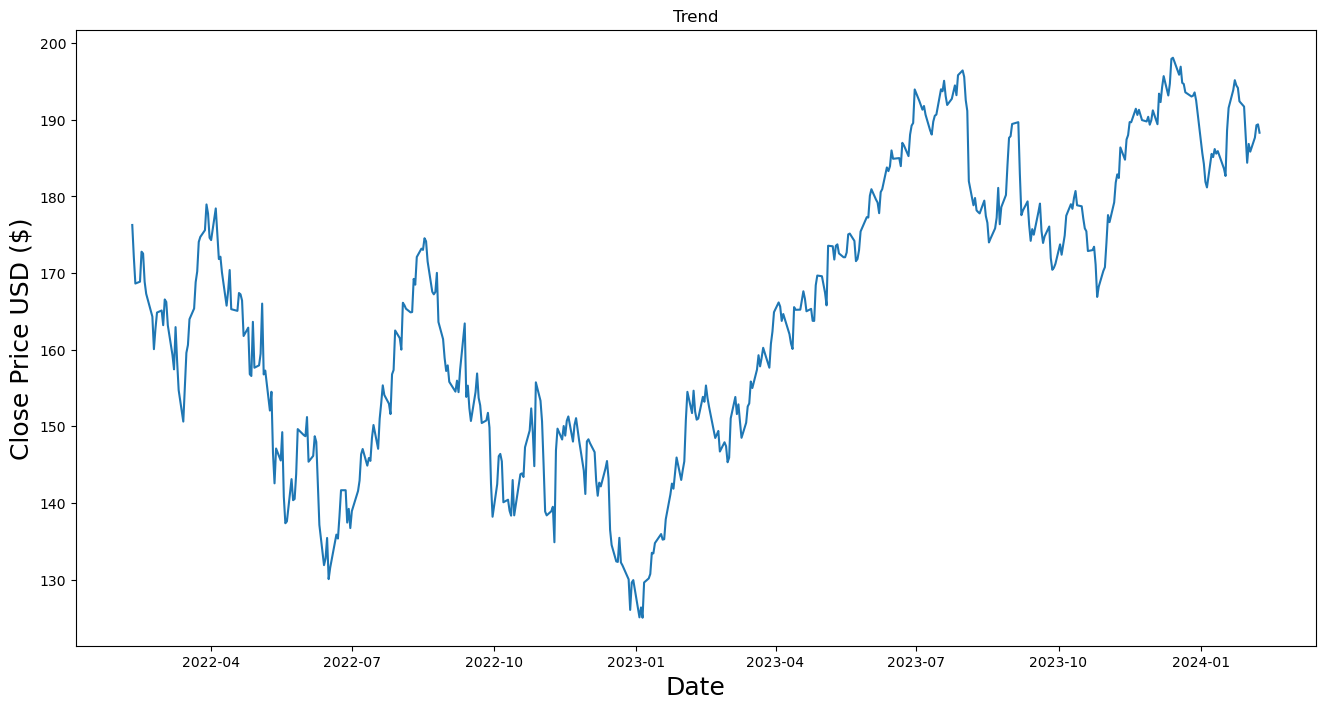

In [9]:
# To filter negative values
data.index[data['close'] < 0]

plt.figure(figsize=(16,8))
plt.plot(data['date'], data['close'])
plt.title('Trend')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### 2. Convert Data to stationery

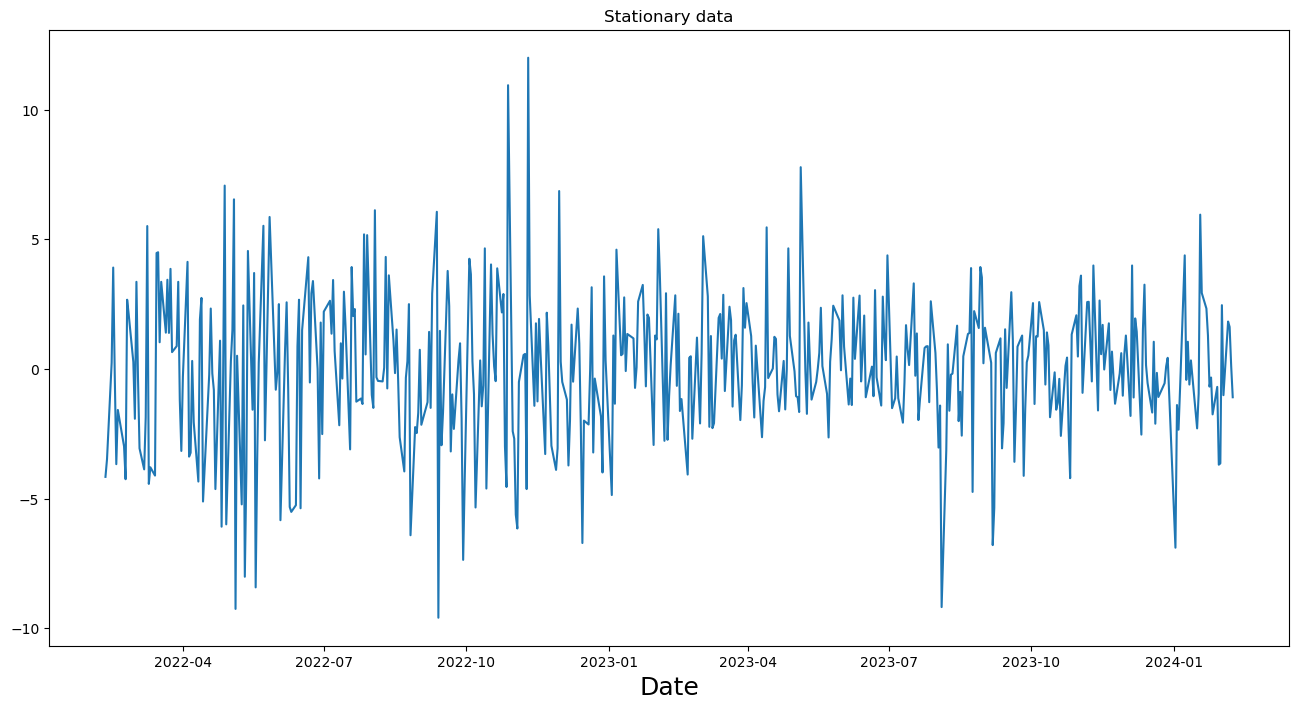

,date,close,close shift
0,2022-02-09,176.279999,NaN
1,2022-02-10,172.119995,-4.160004
2,2022-02-11,168.639999,-3.479996
3,2022-02-14,168.880005,0.240005
4,2022-02-15,172.789993,3.909988
...,...,...,...
497,2024-02-02,185.850006,-1.009995
498,2024-02-05,187.679993,1.829987
499,2024-02-06,189.300003,1.620010
500,2024-02-07,189.410004,0.110001


Index(['date', 'close', 'close shift'], dtype='object')

In [13]:
# yt = yt-y(t-1) - First differencing formula to convert the data into stationary
data['close shift'] = data['close'].diff()
y = data['close shift']

plt.figure(figsize=(16,8))
plt.plot(data['date'],data['close shift'])
plt.title('Stationary data')
plt.xlabel('Date', fontsize=18)
plt.show()

display(data)
data.columns

In [14]:
prophet_df = data.rename(columns = {'date' : 'ds', 'close shift' : 'y'})

  # Sort the DataFrame by `ds` in ascending order
prophet_df = prophet_df.sort_values('ds', ascending = True)

display(prophet_df)

,ds,close,y
0,2022-02-09,176.279999,NaN
1,2022-02-10,172.119995,-4.160004
2,2022-02-11,168.639999,-3.479996
3,2022-02-14,168.880005,0.240005
4,2022-02-15,172.789993,3.909988
...,...,...,...
497,2024-02-02,185.850006,-1.009995
498,2024-02-05,187.679993,1.829987
499,2024-02-06,189.300003,1.620010
500,2024-02-07,189.410004,0.110001


In [16]:
## Split the Data
train_data_len = int(0.8*len(data))
train_data_len

401

In [17]:
#80% for training and 20% for testing
df_train = prophet_df[:train_data_len]
df_test = prophet_df[train_data_len:]
display(df_train, df_train.shape)
display(df_test, df_test.shape)

,ds,close,y
0,2022-02-09,176.279999,NaN
1,2022-02-10,172.119995,-4.160004
2,2022-02-11,168.639999,-3.479996
3,2022-02-14,168.880005,0.240005
4,2022-02-15,172.789993,3.909988
...,...,...,...
396,2023-09-08,178.179993,0.619995
397,2023-09-11,179.360001,1.180008
398,2023-09-12,176.300003,-3.059998
399,2023-09-13,174.210007,-2.089996


(401, 3)

,ds,close,y
401,2023-09-15,175.009995,-0.730011
402,2023-09-18,177.970001,2.960007
403,2023-09-19,179.070007,1.100006
404,2023-09-20,175.490005,-3.580002
405,2023-09-21,173.929993,-1.560013
...,...,...,...
497,2024-02-02,185.850006,-1.009995
498,2024-02-05,187.679993,1.829987
499,2024-02-06,189.300003,1.620010
500,2024-02-07,189.410004,0.110001


(101, 3)

In [38]:
model = Prophet(changepoint_prior_scale=0.05,
                seasonality_prior_scale=2.0)

# Fit the Prophet model.
model.fit(df_train)

10:25:00 - cmdstanpy - INFO - Chain [1] start processing
10:25:00 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
periods = len(data)-len(df_train)
periods

forecast = model.make_future_dataframe(periods= periods)
display(forecast)

,ds
0,2022-02-09
1,2022-02-10
2,2022-02-11
3,2022-02-14
4,2022-02-15
...,...
497,2023-12-20
498,2023-12-21
499,2023-12-22
500,2023-12-23


In [40]:
# Make Prediction 
prediction = model.predict(forecast)

display(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

,ds,yhat,yhat_lower,yhat_upper
0,2022-02-09,-0.238575,-4.388798,3.576567
1,2022-02-10,-0.445461,-4.079387,3.257086
2,2022-02-11,-0.208596,-3.799327,3.441011
3,2022-02-14,-0.377176,-4.459437,3.646656
4,2022-02-15,-0.288329,-4.141096,3.516755
...,...,...,...,...
497,2023-12-20,0.516705,-3.277389,4.405233
498,2023-12-21,0.309818,-3.876985,4.001174
499,2023-12-22,0.546682,-3.070130,4.488055
500,2023-12-23,-1.789358,-5.910473,2.175436


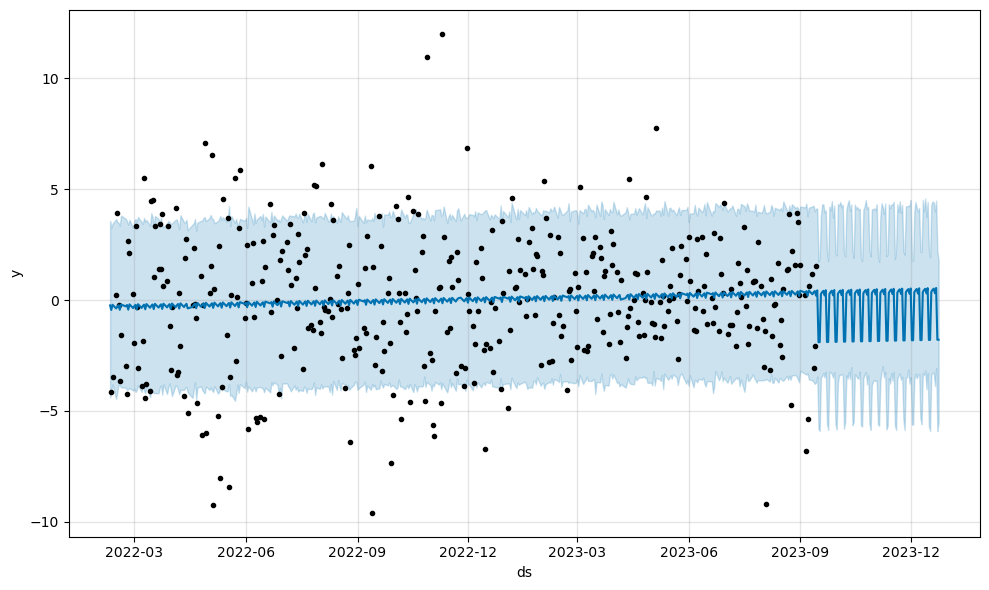

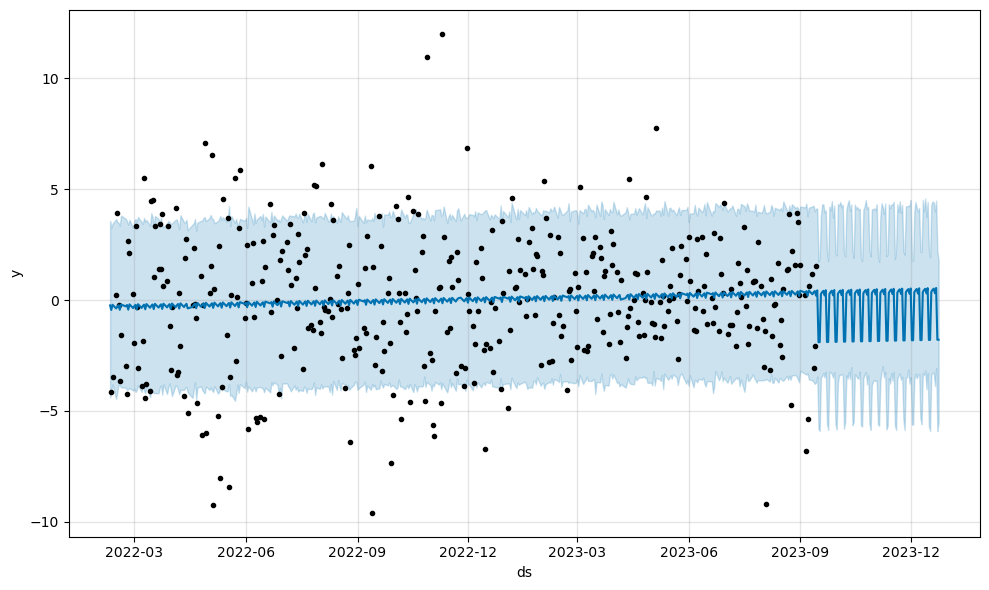

In [41]:
# Plot Our Predictions
model.plot(prediction)

In [45]:
# Merge the forecast with actual values from the test dataset
merged_forecast = prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(df_test[['ds','close', 'y']], on='ds')
display(df_test)
# Display the merged DataFrame
display(merged_forecast)

,ds,close,y
401,2023-09-15,175.009995,-0.730011
402,2023-09-18,177.970001,2.960007
403,2023-09-19,179.070007,1.100006
404,2023-09-20,175.490005,-3.580002
405,2023-09-21,173.929993,-1.560013
...,...,...,...
497,2024-02-02,185.850006,-1.009995
498,2024-02-05,187.679993,1.829987
499,2024-02-06,189.300003,1.620010
500,2024-02-07,189.410004,0.110001


,ds,yhat,yhat_lower,yhat_upper,close,y
0,2023-09-15,0.437694,-3.443461,4.129281,175.009995,-0.730011
1,2023-09-18,0.269111,-3.486909,3.809277,177.970001,2.960007
2,2023-09-19,0.357956,-3.432546,4.305138,179.070007,1.100006
3,2023-09-20,0.415502,-3.281864,4.324240,175.490005,-3.580002
4,2023-09-21,0.208615,-3.486143,3.943428,173.929993,-1.560013
...,...,...,...,...,...,...
65,2023-12-18,0.370314,-3.340280,4.291440,195.889999,-1.680008
66,2023-12-19,0.459160,-3.277414,4.443581,196.940002,1.050003
67,2023-12-20,0.516705,-3.277389,4.405233,194.830002,-2.110001
68,2023-12-21,0.309818,-3.876985,4.001174,194.679993,-0.150009


In [46]:
y_true = merged_forecast['y'].values
y_pred = merged_forecast['yhat'].values

# Assuming y_true and y_pred are the actual and predicted values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

MAE: 1.5223121459610622
RMSE: 1.8751303554622851
R²: -0.011648414963106424
MAPE: 141.12571678174817
